In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
def generateSimulationID(tup):
    identifier = tup[0] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + tup[3] \
            + "_" + tup[4] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


simulation_map = {
    "Watdiv10M": "W10", "Watdiv100M": "W100", "Watdiv1000M": "W1000", "Ontoforce": "Ont"
}

def generateSimulationIDCompact(tup, pref_length=3):
    #pref_length = 3
    identifier = tup[0][:pref_length] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + simulation_map[tup[3]] \
            + "_" + str(tup[4])[:pref_length] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


In [4]:
def generateFilenameQueryEventsCorrect(bmtuple):
    fname = './csv_correct/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents_correct.csv"


def generate_sorted_events_filename(tup):
    return 'query_events_sorted/'+generateSimulationID(tup)+"_events_sorted.csv"

In [5]:
def create_offset_frame_group(g):
    

    m1 = g['flag'] == 'SUCCESS'
    m2 = g['correct'] == 'CORRECT'
    m3 = g['thread_type'] == 'stress'

    g_correct = g[m1 & m2 & m3]

    g_cleaned = g_correct.sort_values('cumul_time').reset_index()
    g_previous = g_cleaned.shift(+1)
    g_previous.dropna(inplace=True)

    diff_cols = ['overall_order_id', 'cumul_time', 'cumul_results']

    g_difference = pd.DataFrame(g_cleaned)
    g_difference.loc[:,diff_cols] = g_cleaned[diff_cols] - g_previous[diff_cols]
    g_difference.loc[:,'thread_id'] = g_cleaned['thread_id'].map(str) + \
                        "-" +  \
                        g_previous['thread_id'].map(lambda s: str(s)[:-2])

            
    g_difference['speedup'] = g_difference['runtime'].max() / g_difference['runtime']
    g_difference['net_gain'] = g_difference['runtime'].max() - g_difference['runtime']

    
    g_difference2 = g_difference.dropna()
    g_difference3 = g_difference2.set_index('index')
    g_difference4 = g_difference3.rename(columns={'cumul_time': 'time_offset', \
                                              'overall_order_id': 'order_offset', \
                                              'cumul_results': 'results_offset'})
       
    return g_difference4 

# 1. Different View: Speedup vs Time (colorize template types)

### Tryout

In [6]:
tup = ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')
df = pd.read_csv(generate_sorted_events_filename(tup), sep='\t', index_col=0)
df.head(n=10)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,correct,cumul_time,overall_order_id,cumul_results
0,Vir_N1_64_W1000_Opt,S5/S5_split14.sparql,1,warmup,1,0,0.873330,SUCCESS,CORRECT,0.873330,0,0
1,Vir_N1_64_W1000_Opt,L1/L1_split17.sparql,1,warmup,2,0,1.318553,SUCCESS,CORRECT,2.191883,1,0
2,Vir_N1_64_W1000_Opt,S1/S1_split12.sparql,1,warmup,3,9,5.462552,SUCCESS,CORRECT,7.654435,2,9
3,Vir_N1_64_W1000_Opt,S6/S6_split17.sparql,1,warmup,4,1567,4.722458,SUCCESS,CORRECT,12.376893,3,1576
4,Vir_N1_64_W1000_Opt,F1/F1_split2.sparql,1,warmup,5,251,0.662693,SUCCESS,CORRECT,13.039586,4,1827
5,Vir_N1_64_W1000_Opt,F5/F5_split10.sparql,1,warmup,6,43,0.544959,SUCCESS,CORRECT,13.584546,5,1870
6,Vir_N1_64_W1000_Opt,S3/S3_split14.sparql,1,warmup,7,0,0.161130,SUCCESS,CORRECT,13.745676,6,1870
7,Vir_N1_64_W1000_Opt,S3/S3_split6.sparql,1,warmup,8,0,0.056398,SUCCESS,CORRECT,13.802074,7,1870
8,Vir_N1_64_W1000_Opt,F5/F5_split6.sparql,1,warmup,9,32,0.023044,SUCCESS,CORRECT,13.825117,8,1902
9,Vir_N1_64_W1000_Opt,F1/F1_split0.sparql,1,warmup,10,251,0.081548,SUCCESS,CORRECT,13.906666,9,2153


In [7]:
colormap1 = {
    "C" : "red",
    "F" : "blue",
    "S" : "green",
    "L" : "orange"
}

In [8]:

grouped_per_query = df.groupby('query_name')

dfs = []
for i, g in grouped_per_query:
    dfs.append(create_offset_frame_group(g))
    
df_offsets = pd.concat(dfs)
df_offsets['color_type'] = df_offsets['query_name'].apply(lambda n: colormap1[n[:1]])
df_offsets.head(n=5)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,correct,time_offset,order_offset,results_offset,speedup,net_gain,color_type
index,,,,,,,,,,,,,,,
737,Vir_N1_64_W1000_Opt,C1/C1_split0.sparql,15-18,stress,94,1424,48.751925,SUCCESS,CORRECT,157.499107,182.0,3547047.0,1.093022,4.534985,red
1389,Vir_N1_64_W1000_Opt,C1/C1_split0.sparql,17-15,stress,169,1424,49.794759,SUCCESS,CORRECT,672.043656,652.0,35423030.0,1.070131,3.492152,red
1551,Vir_N1_64_W1000_Opt,C1/C1_split0.sparql,14-17,stress,207,1424,53.286911,SUCCESS,CORRECT,158.560836,162.0,5661080.0,1.000000,0.000000,red
1865,Vir_N1_64_W1000_Opt,C1/C1_split0.sparql,16-14,stress,280,1424,48.074759,SUCCESS,CORRECT,309.018873,314.0,18519996.0,1.108418,5.212152,red
1042,Vir_N1_64_W1000_Opt,C1/C1_split1.sparql,15-14,stress,168,1424,46.815565,SUCCESS,CORRECT,559.219708,582.0,28858075.0,1.086551,4.051953,red


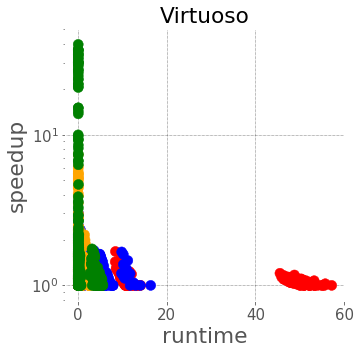

In [9]:

ax = df_offsets.plot(kind='scatter', x='runtime', y='speedup', c=df_offsets['color_type'], logy=True, figsize=(5,5), s=100)
ax.set_title('Virtuoso')

### Full Visualization

In [10]:
colormap1 = {
    "C" : "red",
    "F" : "blue",
    "S" : "green",
    "L" : "orange"
}

tuple_list = [ \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
                ('ES', 1, 64,'Watdiv1000M', 'Default', '')          , \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', '')   , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')  , \
                ('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
                ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
                #('FluidOps', 3, 64,'Watdiv100M', 'Default', ''), \
                ('LDF', 3, 64,'Watdiv100M', 'Default', '')  
             ]

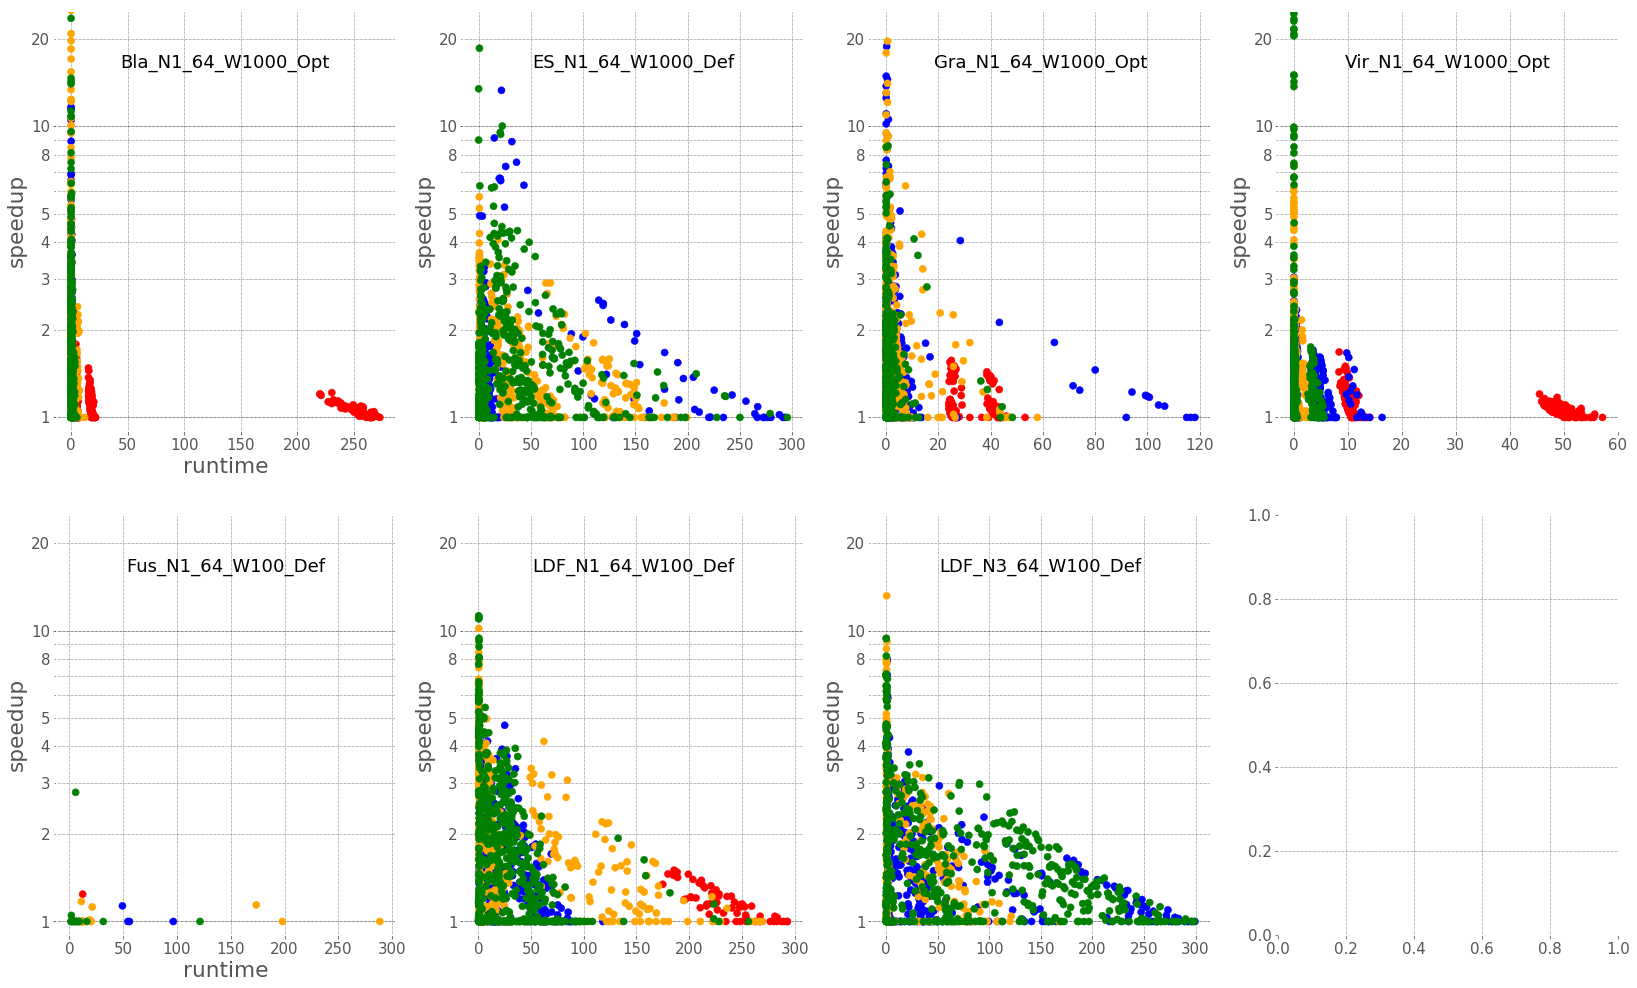

In [12]:
fig, ax = plt.subplots(2,4, figsize=(28,17), sharey=False)

for i, tup in enumerate(tuple_list):
    p = i // 4
    q = i % 4 
    
    df = pd.read_csv(generate_sorted_events_filename(tup), sep='\t', index_col=0)

    grouped_per_query = df.groupby('query_name')

    dfs = []
    for i, g in grouped_per_query:
        dfs.append(create_offset_frame_group(g))
    
    df_offsets = pd.concat(dfs)
    df_offsets['color_type'] = df_offsets['query_name'].apply(lambda n: colormap1[n[:1]])
    
    df_offsets.plot(kind='scatter', x='runtime', y='speedup', c=df_offsets['color_type'], logy=True, logx=False, \
                    s=50, ax=ax[p][q], grid=True, ylim=[9e-1, 25])

    
    ax[p][q].set_yticklabels([])    
    ax[p][q].set_title(generateSimulationIDCompact(tup), fontsize=18, y=0.85, x=0.5 )
    ax[p][q].set_yticks([1,2,3,4,5,6,7,8,9,10,20], minor=True)
    ax[p][q].set_yticklabels([1,2,3,4,5,'','',8,'',10,20], minor=True)    
    
    ax[p][q].grid('on', which='minor', axis='x' )
    ax[p][q].grid('on', which='minor', axis='y' )


    if q !=0:
        ax[p][q].set_xlabel("")
        
fname= './img/caching/Watdiv_caching'
plt.savefig(fname+'.svg', format='svg', bbox_inches='tight', dpi=400)
plt.savefig(fname+'.eps', format='eps', bbox_inches='tight', dpi=200)   
plt.savefig(fname+'.pdf', format='pdf', bbox_inches='tight', dpi=1200)        


#fname= './img/ForPaper/Watdiv_caching'
#plt.savefig(fname+'.svg', format='svg', bbox_inches='tight', dpi=400)
#plt.savefig(fname+'.eps', format='eps', bbox_inches='tight', dpi=200)  
#plt.savefig(fname+'.pdf', format='pdf', bbox_inches='tight', dpi=1200)        


# 2. Ontoforce Queries?

* Not very relevant, most engines didn't get to the stress test phase => every was executed only once in most cases